In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wmfdata as wmf

from wmfdata.utils import (
    pct_str,
    pd_display_all
)

In [3]:
wmf.charting.set_mpl_style()

## Data caveats
* The experiment was released to the KaiOS store on 8 April, in version 1.6.0 of the app. On 5 May, we [fixed](https://www.mediawiki.org/w/index.php?title=Wikipedia_for_KaiOS/engagement1&diff=4563366&oldid=4520262) a vandalization of our config that prevent the recommendations from being shown.
* After the scheduled publication of recommendations on 2 June at 03:00 UTC, an infrastructure issue prevented new recommendations from being published (although the existing recommendations continued to be served to app users). The issue was fixed and updated set of recommendations were published on 4 June at 23:00 UTC, followed by scheduled updates as normal.
* There was a significant break in the trending articles job, from 6 October through 20 October (the trending articles from 5 October continued to be displayed during this period).

## Data storage

Log of updates:
* 2021-07-29: stored data for \[2021-05-06, 2021-07-27\] in `neilpquinn.kaios_experiment_event`
* 2021-09-07: stored data for \[2021-07-28, 2021-09-05\] in `neilpquinn.kaios_experiment_event`
* 2021-10-21: stored data for \[2021-07-23, 2021-10-20\] in `nshahquinn.kaios_experiment_event` (with extra columns `dt` and `wiki`).
* 2021-11-05: stored data for \[2021-10-21, 2021-11-04\] in `nshahquinn.kaios_experiment_event`
* 2021-11-11: combined all existing data in `nshahquinn.kaios_experiment_event_combined` (see work log).

In [4]:
SPARK_PARTITION_DATE = (
    "CONCAT("
        "CAST(year AS STRING), '-', "
        "LPAD(CAST(month AS STRING), 2, '0'), '-', "
        "LPAD(CAST(day AS STRING), 2, '0')"
    ")"
)

# Both start and end dates are included
START_DATE = "2021-10-21"
END_DATE = "2021-11-04"

In [ ]:
wmf.spark.run("""
CREATE TABLE nshahquinn.kaios_experiment_event (
    dt STRING,
    client_dt STRING,
    server_dt STRING,
    pageview_id STRING,
    session_id STRING,
    user_id STRING,
    load_dt STRING,
    page_open_time BIGINT,
    page_visible_time BIGINT,
    section_count BIGINT,
    opened_section_count BIGINT,
    is_main_page BOOLEAN,
    page_namespace BIGINT,
    wiki STRING,
    experiment_group STRING,
    country STRING,
    country_subdivision STRING,
    app_version STRING
) STORED AS PARQUET
""")

In [ ]:
wmf.spark.run(f"""
INSERT INTO TABLE nshahquinn.kaios_experiment_event
SELECT
    dt,
    client_dt,
    meta.dt AS server_dt,
    event.pageview_token AS pageview_id,
    event.session_id AS session_id,
    event.user_id AS user_id,
    event.load_dt AS load_dt,
    event.page_open_time AS page_open_time,
    event.page_visible_time AS page_visible_time,
    event.section_count AS section_count,
    event.opened_section_count AS opened_section_count,
    event.is_main_page AS is_main_page,
    event.page_namespace AS page_namespace,
    wiki,
    event.tests[0].`group` AS experiment_group,
    geocoded_data["country_code"] AS country,
    geocoded_data["subdivision"] AS country_subdivision,
    event.app_version AS app_version
FROM event.inukapageview
WHERE
    {SPARK_PARTITION_DATE} BETWEEN '{START_DATE}' AND '{END_DATE}'
    AND SIZE(event.tests) > 0
    AND event.is_production
""")

The drop in events starting on 29 August is expected, since that's when KaiOS stopped running ads for our app in their ad network.

## Data exploration

In [145]:
wmf.presto.run("""
SELECT
    country IN ('NG', 'PK', 'TZ', 'UG') as focus_country,
    COUNT(*) AS events,
    COUNT(DISTINCT user_id) AS users
FROM nshahquinn.kaios_experiment_event_combined
GROUP BY country IN ('NG', 'PK', 'TZ', 'UG')
""")

,focus_country,events,users
0,True,1399422,107685
1,False,1180708,45181


In [146]:
wmf.presto.run("""
SELECT
    app_version,
    COUNT(*) AS events
FROM nshahquinn.kaios_experiment_event_combined
GROUP BY app_version
""")

,app_version,events
0,0.0.0,555
1,1.6.0,2579189
2,1.7.0.0,224
3,1.8.1.0,162


In [147]:
user_agg = wmf.presto.run("""
SELECT
    user_id,
    ARRAY_JOIN(SET_AGG(country), '-') AS country,
    ARRAY_JOIN(SET_AGG(experiment_group), '-') AS experiment_group,
    ARRAY_JOIN(SET_AGG(wiki), '-') AS wiki
FROM nshahquinn.kaios_experiment_event_combined
GROUP BY user_id
""")

In [148]:
user_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152784 entries, 0 to 152783
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           152784 non-null  object
 1   country           152784 non-null  object
 2   experiment_group  152784 non-null  object
 3   wiki              152784 non-null  object
dtypes: object(4)
memory usage: 4.7+ MB


In [149]:
focus_users_all_wikis = (
    user_agg
    .query(
        "country in ('NG', 'PK', 'TZ', 'UG') "
        "and experiment_group in ('control', 'trending-articles')"
    )
)

In [94]:
focus_users_all_wikis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51998 entries, 0 to 85446
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           51998 non-null  object
 1   country           51998 non-null  object
 2   experiment_group  51998 non-null  object
 3   wiki              51998 non-null  object
dtypes: object(4)
memory usage: 2.0+ MB


In [150]:
(
    focus_users_all_wikis
    .groupby('wiki')
    .size()
    .sort_values(ascending=False)
    .head(20)
)

wiki
                 55608
enwiki           47096
swwiki             642
enwiki-swwiki      392
enwiki-            379
swwiki-enwiki      362
enwiki-dewiki      315
urwiki             292
enwiki-urwiki      237
urwiki-enwiki      162
frwiki             109
nlwiki             108
enwiki-nlwiki      108
enwiki-frwiki      107
enwiki-eswiki      103
nlwiki-enwiki       90
enwiki-itwiki       73
enwiki-afwiki       63
dewiki-enwiki       59
enwiki-svwiki       45
dtype: int64

* Remove entire users if they switch countries or groups

In [175]:
user = wmf.presto.run(f"""
WITH pageview AS (
    SELECT
        pageview_id,
        session_id,
        user_id,
        MIN(server_dt) AS start_time,
        MAX(
            -- Convert milliseconds to minutes
            CAST(page_visible_time AS REAL) / 1000 / 60
        ) AS page_viewing_min,
        ARRAY_JOIN(SET_AGG(country), '-') AS country,
        ARRAY_JOIN(SET_AGG(experiment_group), '-') AS experiment_group,
        ARRAY_JOIN(SET_AGG(wiki), '-') AS wiki
    FROM nshahquinn.kaios_experiment_event_combined
    WHERE
        app_version = '1.6.0'
    GROUP BY
        pageview_id,
        session_id,
        user_id
), session AS (
    SELECT
        session_id,
        user_id,
        MIN(start_time) AS start_time,
        SUM(page_viewing_min) AS page_viewing_min,
        ARRAY_JOIN(SET_AGG(country), '-') AS country,
        ARRAY_JOIN(SET_AGG(experiment_group), '-') AS experiment_group,
        ARRAY_JOIN(SET_AGG(wiki), '-') AS wiki
    FROM pageview
    GROUP BY
        user_id,
        session_id
), user AS (
    SELECT
        user_id,
        MIN(start_time) AS experiment_entry,
        CAST(DATE_DIFF('second', MIN(start_time), CURRENT_TIMESTAMP) AS REAL) / 60 / 60 / 24  AS days_in_experiment,
        COUNT(1) AS sessions,
        AVG(page_viewing_min) AS mean_session_min,
        ARRAY_JOIN(SET_AGG(country), '-') AS country,
        ARRAY_JOIN(SET_AGG(experiment_group), '-') AS experiment_group,
        ARRAY_JOIN(SET_AGG(wiki), '-') AS wiki
    FROM session
    GROUP BY user_id
)
SELECT
    user_id,
    experiment_entry,
    days_in_experiment,
    sessions,
    mean_session_min,
    country,
    wiki,
    experiment_group
FROM user
WHERE
    country IN ('NG', 'PK', 'TZ', 'UG')
    AND experiment_group IN ('control', 'trending-articles')
""").assign(
    experiment_entry=lambda df: pd.to_datetime(df["experiment_entry"]),
    country=lambda df: df["country"].astype("category"),
    experiment_group=lambda df: df["experiment_group"].astype("category"),
    wiki=lambda df: df["wiki"].astype("category")
)

In [176]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107600 entries, 0 to 107599
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   user_id             107600 non-null  object        
 1   experiment_entry    107600 non-null  datetime64[ns]
 2   days_in_experiment  107600 non-null  float64       
 3   sessions            107600 non-null  int64         
 4   mean_session_min    107600 non-null  float64       
 5   country             107600 non-null  category      
 6   wiki                107600 non-null  category      
 7   experiment_group    107600 non-null  category      
dtypes: category(3), datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 4.6+ MB


# Data exploration

## Users by countries and experiment groups

In [177]:
pd.pivot_table(
    user,
    # The column used for `values` means nothing since we use `len` as the `aggfunc`.
    values="user_id",
    index="country",
    columns="experiment_group",
    aggfunc=len,
    margins=True
)

experiment_group,control,trending-articles,All
country,,,
NG,7241,7172,14413
PK,23610,23417,47027
TZ,16396,16406,32802
UG,6693,6665,13358
All,53940,53660,107600


## Session duration

In [178]:
user["mean_session_min"].describe()

count    107600.000000
mean         10.359003
std        1032.089287
min        -533.543760
25%           0.382450
50%           1.095358
75%           2.517921
max      252486.750000
Name: mean_session_min, dtype: float64

In [179]:
with pd.option_context("display.min_rows", 30):
    display(user["mean_session_min"].sort_values(ascending=False))

10632     252486.750000
23345     110552.320000
38783     101221.140000
102661     89552.820000
47309      89305.610000
55903      88719.090000
84104      39641.605000
41374      39428.207000
10404      32997.098000
68299      12894.256000
38437      12634.044000
18228        396.418600
70692        173.118800
3965         146.368550
9207         123.104260
              ...      
74893          0.002267
94734          0.002117
96324          0.002067
88276          0.002067
88011          0.002050
84839          0.001900
73421          0.001167
51832          0.001117
50821          0.001017
100767         0.000950
99270          0.000883
103730        -0.015567
11689         -0.030742
66658         -0.748583
60793       -533.543760
Name: mean_session_min, Length: 107600, dtype: float64

Some users have pathological session lengths. Let's remove them.

In [180]:
user = user.query("mean_session_min >= 0 and mean_session_min < 600")

In [181]:
user["mean_session_min"].describe()

count    107585.000000
mean          2.284055
std           4.255391
min           0.000883
25%           0.382450
50%           1.095133
75%           2.517450
max         396.418600
Name: mean_session_min, dtype: float64

In [182]:
# Proportion of users with mean session length of 10 minutes or more
print(pct_str(user["mean_session_min"][lambda x: x >= 10].pipe(len) / len(user)))

3.6%


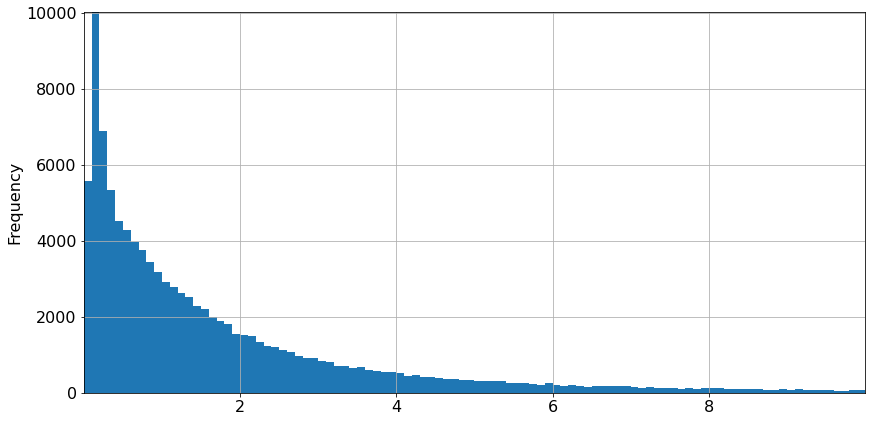

In [183]:
user["mean_session_min"][lambda x: x < 10].plot(kind='hist', bins=100);

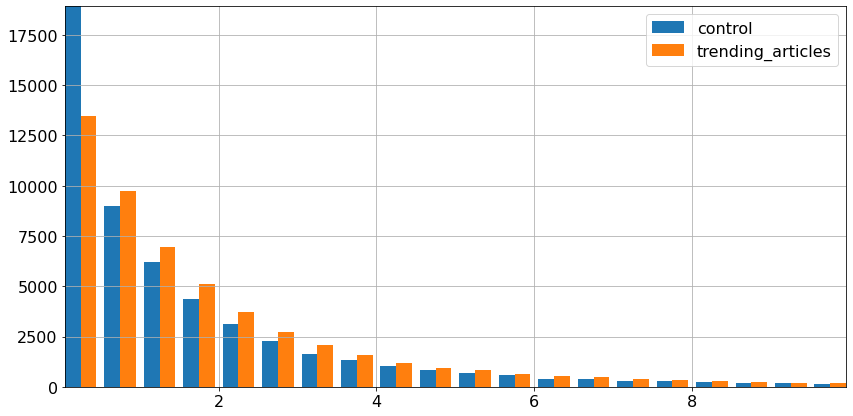

In [184]:
control_session_lengths = user.query("experiment_group == 'control'")["mean_session_min"][lambda x: x <= 10]
trending_articles_session_lengths = user.query("experiment_group == 'trending-articles'")["mean_session_min"][lambda x: x <= 10]

plt.hist([control_session_lengths, trending_articles_session_lengths], bins=20, label=["control", "trending_articles"])
plt.legend();

## Session count

In [185]:
user["sessions"].describe()

count    107585.000000
mean          2.056699
std           3.283368
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         321.000000
Name: sessions, dtype: float64

In [186]:
# Proportion of users with ten sessions or more
print(pct_str(user["sessions"][lambda x: x >= 10].pipe(len) / len(user)))

1.2%


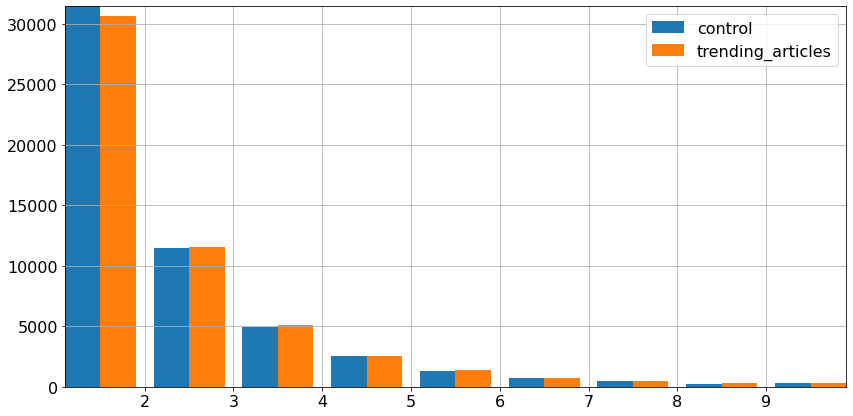

In [187]:
control_session_counts = user.query("experiment_group == 'control'")["sessions"][lambda x: x <= 10]
trending_articles_session_counts = user.query("experiment_group == 'trending-articles'")["sessions"][lambda x: x <= 10]

plt.hist([control_session_counts, trending_articles_session_counts], bins=9, label=["control", "trending_articles"])
plt.legend();

In [188]:
user["experiment_entry"].describe(datetime_is_numeric=True)

count                           107585
mean     2021-07-10 13:17:27.458060800
min         2021-05-06 00:00:00.350000
25%         2021-06-07 03:30:42.868000
50%      2021-07-08 13:15:46.684999936
75%      2021-08-08 13:43:10.230000128
max         2021-11-04 22:59:03.917000
Name: experiment_entry, dtype: object

In [189]:
user["days_in_experiment"].describe()

count    107585.000000
mean        124.198232
std          41.016205
min           6.794340
25%          95.180370
50%         126.199400
75%         157.605700
max         189.752010
Name: days_in_experiment, dtype: float64

## Correlations

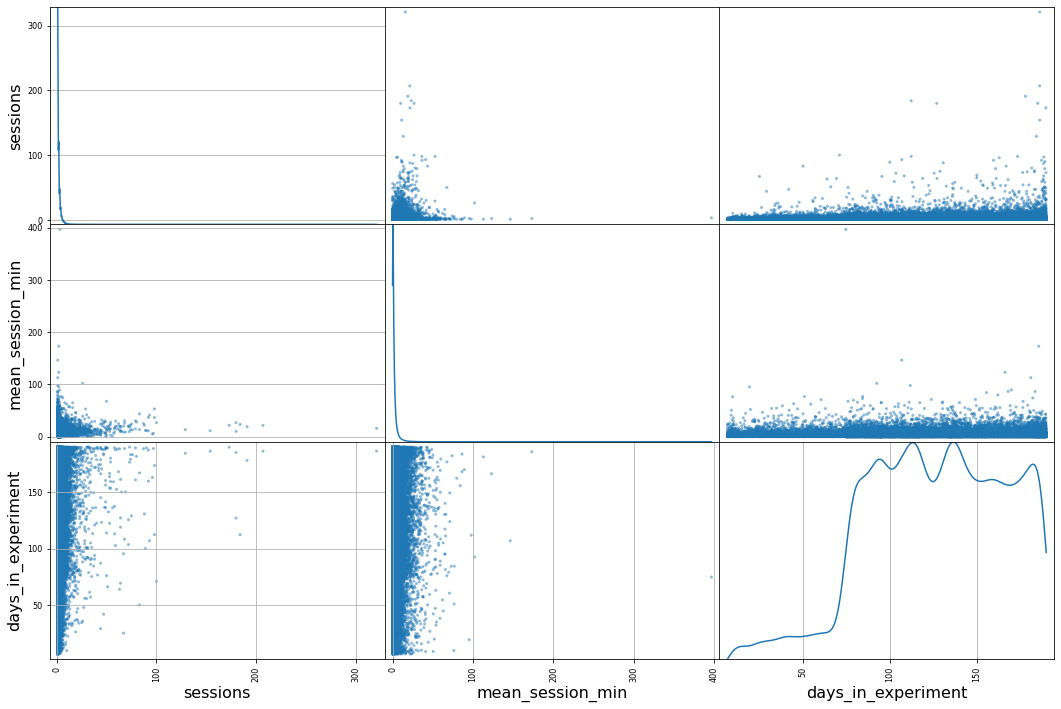

In [190]:
pd.plotting.scatter_matrix(
    user[["sessions", "mean_session_min", "days_in_experiment"]],
    diagonal="kde",
    figsize=(18, 12)
);

In [192]:
user.corr()

,days_in_experiment,sessions,mean_session_min
days_in_experiment,1.000000,0.054084,-0.007204
sessions,0.054084,1.000000,0.202962
mean_session_min,-0.007204,0.202962,1.000000


In [193]:
# We should actually save this as a timestamped file, so we can cleanly replicate the analysis
user.to_parquet('data/2021-11-11_experiment_user.parquet')